# Intuit craft demonstration

### Kyle Willett (Fellow, Insight Data Science)

* <font color='red'>*Create a reasonable definition(s) of rule performance.*</font>

    The definition of rule performance I used involves three related measures of success: **precision**, **recall**, and the combined **F1-score**. This primarily evaluates the decisions of the risk agents, where a (true) positive result occurred when a rule was triggered, the agent withheld funds, and the case was ultimately labeled as fraud. A poorly-performing rule is one where a trigger either meant the agent released the funds the majority of the time (which would mean the rule is too sensitive to false positives) or with a high rate of released funds for cases labeled as fraud (which would mean that the agents do not recognize the merits of this rule).
    
    I calculated **precision**, **recall**, and **F1** for each rule based on the rates of held funds and bad cases. Roughly 1/3 of the rules (11/30) have high marks for both precision and recall and have triggered a sufficient number of alerts that their performance is fairly well characterized. A second group of rules (10/30) have enough triggers to measure their performance, but low precision and recall scores; these should be re-assessed and potentially modified to lower the number of false detections. The remaining 9/30 rules either have very few triggers and/or exhibit rapidly changing behavior, and need more triggers before their effectiveness can be evaluated. 

    I also looked at performance grouped by the overall rule type. **Fraud** rules have by a significant amount the best performance across all three metrics. **Financial risk** has comparable precision, but much worse recall. Metrics for both fraud and financial risk stabilized after $\sim1$ month of collecting data. **Compliance** metrics are poor both in precision and recall, and have been mildly but steadily decreasing over the last two months of data.
    

* <font color='red'>*Build a mockup of a dashboard(s) that tracks rules performance (by rule and by RiskAlertCategory) in whatever way you think is appropriate (there may be multiple ways to assess performance).*</font>

    The dashboards I built are static plots in Python/Jupyter notebook, although the queries are run against a SQL database (PostgreSQL for this example) that can be updated with new data. The dashboard can be easily updated with more recent data. The key plot shows the precision, recall, and F1 scores split by rule and plotted over an expanding time window (taking in all data up to the current point). It shows the relative stability and performance of each rule simultaneously. 
    
    For the daily business of risk agents, the performance is plotted over a rolling window so that agents can assess the recent performance of each rule as well. 


* <font color='red'>*Assess the overall decision making process (which includes Risk Agents’ decisions).*</font>

    Evaluation of the decision making process relies heavily on two pieces of data that are not included in this set. The first set would be the actual true negatives: cases of daily transactions that did not trigger a rule. Information on this would provide a baseline on the sensitivity of a particular rule to both holding funds and ultimate investigation into whether a transaction is fraudulent. 
    
    Secondly, there is no information on the risk agent handling each of the individual cases. This information is potentially important because of the human factor involved; a particular risk agent, for example, will have varying levels of accuracy (either overall or with respect to particular rules), each of which could be modeled. If so, that would allow better assessment of the rule performance since the effect of a particular user agent can be marginalized. This information could also be attached via anonymized ID in the same case table. 

## Import data to SQL database

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
import pandas as pd # Requires v 0.18.0
import numpy as np

import seaborn as sns
sns.set_style("whitegrid")

//anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
dbname = 'risk'
username = 'willettk'
# Note: password must be entered to run, but don't put this anywhere public.
psswd = ''

In [4]:
engine = create_engine('postgresql://%s:%s@localhost/%s'%(username,psswd,dbname))

# Check if database exists
database_exists(engine.url)

True

In [7]:
# Load the risk databases from CSV files

cases = pd.read_csv('risk_data/cases.csv',
                             parse_dates=['alertDate'],
                             infer_datetime_format=True)
cases.rename(columns=lambda x: x.lower(), inplace=True)
print cases.dtypes
cases.head()

merchantid             int64
caseid                 int64
alertdate     datetime64[ns]
held                   int64
amount               float64
badmerch               int64
dtype: object


,merchantid,caseid,alertdate,held,amount,badmerch
0,3,122926934,2015-03-30,0,250.00,1
1,8,122327900,2015-03-02,0,136.26,0
2,9,122326508,2015-03-02,0,23629.64,1
3,10,122324830,2015-03-02,0,2096.85,0
4,11,122327662,2015-03-02,0,60.56,0


In [8]:
rules = pd.read_csv('risk_data/rules.csv')
rules.rename(columns=lambda x: x.lower(), inplace=True)
rules.head()

,caseid,ruleid
0,121762798,22
1,121762802,6
2,121762804,14
3,121762804,15
4,121762804,27


In [9]:
categories = pd.read_csv('risk_data/ruleCategories.csv')
categories.rename(columns=lambda x: x.lower(), inplace=True)
categories.head()

,ruleid,ruletype
0,1,Fraud
1,2,Financial Risk
2,3,Financial Risk
3,4,Compliance
4,5,Compliance


In [10]:
# Insert tables into PostgreSQL

cases.to_sql('cases', engine, if_exists='replace', index=False)
rules.to_sql('rules', engine, if_exists='replace', index=False)
categories.to_sql('categories', engine, if_exists='replace', index=False)

In [11]:
# As when setting up PSQL, the connection will need the password for the database entered here

con = psycopg2.connect(database = dbname, user = username, host='localhost', password=psswd)

## Descriptive statistics

In [53]:
# How many different rules are there, grouped by type?

sql_query = """
SELECT ruletype,COUNT(ruletype)
FROM categories
GROUP BY ruleType;
"""
pd.read_sql_query(sql_query,con).head()

,ruletype,count
0,Fraud,10
1,Financial Risk,15
2,Compliance,5


In [14]:
# Are there cases triggered without any money involved in the transaction?

sql_query = """
SELECT COUNT(caseid)
FROM cases
WHERE amount = 0;
"""
pd.read_sql_query(sql_query,con).head()

,count
0,874


Plot the distribution of money involved per transaction. There are ~900 cases where no money was exchanged, but an alert was still triggered. These are potential bad data points, and might need to be removed from the sample. I'd consult with other members of the team to determine whether that would be appropriate. The distribution of money spent is roughly log-normal. 

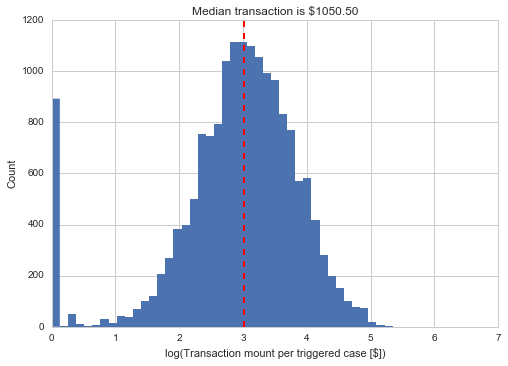

In [57]:
pl = np.log10(cases.amount+1).hist(bins=50)
pl.set_xlabel("log(Transaction mount per triggered case [$])")
pl.set_ylabel("Count")
pl.axvline(np.log10(cases.amount.median()),color='r',lw=2,ls='--')
pl.set_title("Median transaction is ${:.2f}".format(cases.amount.median()));

In [59]:
cases.amount.max()

2316778.79

In [17]:
# What are the distributions of outcomes with regard to holds and bad merchants?

sql_query = """
SELECT held, badmerch, COUNT(badmerch) as c
FROM cases
GROUP BY held,badmerch;
"""
p = pd.read_sql_query(sql_query,con)
p.head()

,held,badmerch,c
0,1,1,2039
1,0,0,11262
2,0,1,2563
3,1,0,1032


In [20]:
# How many total cases are there?

print "Total number of cases in this data set: {}".format(len(cases))

Total number of cases in this data set: 16896


In [21]:
# Does the number of rules violations equal the number of helds?

print len(rules)
print sum(cases.held)

20325
3071


In [22]:
# Are there rules violations that don't correspond to cases in the table?

sql_query = """
SELECT COUNT(rules.caseid)
FROM rules
LEFT JOIN cases ON cases.caseid = rules.caseid
WHERE cases.caseid IS NULL;
"""
pd.read_sql_query(sql_query,con).head()

,count
0,0


No - every case in the `cases` table is associated with at least one rule triggering an alert.

//anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


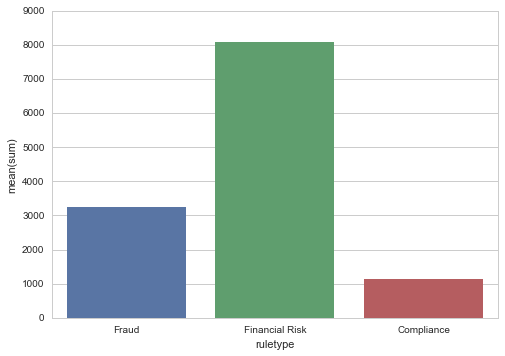

In [24]:
# Look at the distribution of rule types for benign cases

sql_query = """
SELECT ruletype,sum(count) FROM
(SELECT X.count, categories.ruletype FROM 
    (SELECT rules.ruleid, COUNT(rules.ruleid)
        FROM rules
        LEFT JOIN cases ON cases.caseid = rules.caseid
        WHERE cases.held = 0
            AND cases.badmerch = 0
        GROUP BY rules.ruleid) X
    JOIN categories ON categories.ruleid = X.ruleid
    ) Y
GROUP BY ruletype
;
"""
ruletypes_clean = pd.read_sql_query(sql_query,con)

ax = sns.barplot(x="ruletype", y="sum", data=ruletypes_clean)

## Defining metrics

So they're asking for a dashboard that predicts "rules performance". I have individual cases, some of which had funds withheld because of rules performance, and then some fraction of those which were flagged as actual bad cases following judgement by a human. 

So the rules performance is strictly whether a case is likely to have funds automatically withheld and forwarded to a human for review. The `badmerch` label is another level on top of that; the current success ratio should be a measure of how successful the automated system is. 

Based on the outcomes above, a 4:1 ratio might not be considered particularly successful.  

* 66% of cases were not held and ultimately were good. (TN)
* 15% of cases were not held, but turned out to be bad. (FN) 
*  6% of cases were held but turned out to be OK. (FP) 
* 12% of cases were held and did turn out to be bad. (TP)

In [58]:
# Define helper functions for computing metrics of rule performance

def get_precision(TP,FP):

     return TP* 1./ (TP + FP)
    
def get_recall(TP,FN):

     return TP * 1./(TP + FN)
    
def get_accuracy(TP,FP,TN,FN):

     return (TP + TN) * 1./ (TN+FN+FP+TP)
    
def get_f1(TP,FP,TN,FN):
    precision = get_precision(TP,FP)
    recall = get_recall(TP,FN)
    return 2*precision*recall / (precision+recall)

In [19]:
# Print metrics for entire dataset

TN,FN,FP,TP = p.c / sum(p.c)

print "Precision: {:.3f}".format(get_precision(TP,FP))
print "Recall: {:.3f}".format(get_recall(TP,FN))
print "Accuracy: {:.3f}".format(get_accuracy(TP,FP,TN,FN))
print "F1: {:.3f}".format(get_f1(TP,FP,TN,FN))

Precision: 0.287
Recall: 0.084
Accuracy: 0.182
F1: 0.130


I have a label that predicts both a specific rule and its associated class for each transaction. So a reasonable ordered set of priorities might be:

* predict whether \$\$ will be held (ie, a rule is triggered)
* predict what type of rule will be triggered
* predict which specific rule will be triggered
* predict whether a triggered case will ultimately be determined to be fraudulent

I'll need to engineer some of my own features here (ie, for each case I could do something like number of past cases, number of past bad cases, average money in transactions, average time between transactions, etc). Whatever interesting/potential combinations I can get from the ID, time, cost, and history. 

Then I need to turn that into a "dashboard" - that could be both a visualization of past results and/or some mockup of a "current" day's activity and who my results would flag.

## Outcome as a function of rule type

The next step in the analysis will be to make some plots and assess how the rules being trigger vary by rule and rule type. 

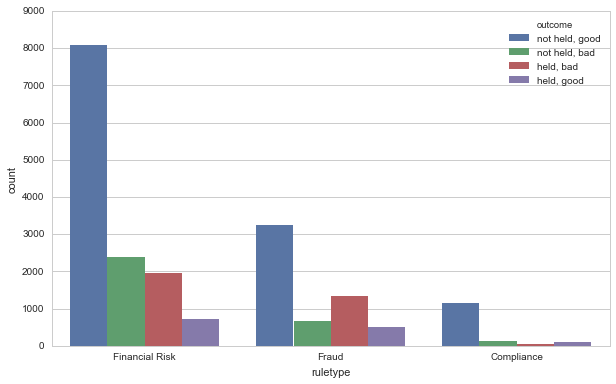

In [25]:
sql_query = """
SELECT X.ruleid, X.caseid, X.outcome, categories.ruletype FROM 
    (SELECT rules.ruleid, rules.caseid,
        CASE
            WHEN cases.held = 0 and cases.badMerch = 0 THEN 'not held, good'
            WHEN cases.held = 0 and cases.badMerch = 1 THEN 'not held, bad'
            WHEN cases.held = 1 and cases.badMerch = 0 THEN 'held, good'
            WHEN cases.held = 1 and cases.badMerch = 1 THEN 'held, bad'
        END outcome
        FROM rules
        LEFT JOIN cases ON cases.caseid = rules.caseid
        ) X
    JOIN categories ON categories.ruleid = X.ruleid
    ;
"""
allcases = pd.read_sql_query(sql_query,con)

fig,ax = plt.subplots(1,1,figsize=(10,6))
sns.countplot(x="ruletype", hue="outcome", data=allcases, ax=ax);

So the distribution of outcomes is very different depending on the overall rule type. Let's look at the actual numbers in each category. 

In [26]:
for g in allcases.groupby("ruletype"):
    for gg in g[1].groupby("outcome"):
        print "{:15}, {:15}, {:2.1f}%".format(g[0],gg[0],len(gg[1]) * 100./len(g[1]))
    print ""

Compliance     , held, bad      , 3.1%
Compliance     , held, good     , 7.4%
Compliance     , not held, bad  , 8.4%
Compliance     , not held, good , 81.1%

Financial Risk , held, bad      , 14.9%
Financial Risk , held, good     , 5.5%
Financial Risk , not held, bad  , 18.2%
Financial Risk , not held, good , 61.4%

Fraud          , held, bad      , 23.1%
Fraud          , held, good     , 9.0%
Fraud          , not held, bad  , 11.5%
Fraud          , not held, good , 56.4%



This data splits the number of alerts by the category of the triggering rule and the ultimate outcome. In every category, the most common outcome is that funds were not withheld and there was no corresponding loss. However, the ratio of outcomes varies strongly by rule type. For rules on compliance, more than 80% of cases are benign and flagged as such. The benign fraction drops to 61% for financial risk and 56% for fraud. So the type of rule being broken is strongly correlated with the likelihood of a bad transaction. 

## Results: assessing performance

The challenge from Intuit is specifically to assess **rule performance**. I interpret that as evaluating individually whether each of these rules is doing well, based on the ultimate accuracy. 

The approach I'll begin with is to look at the rates of the various outcomes for each rule as a function of some metric (precision, accuracy, F1). 

### Splitting by rule: performance metrics

In [27]:
# Retrieve the outcomes of all triggered cases and encode those outcomes as numeric data

sql_query = """
SELECT X.ruleid, X.caseid, X.outcome, categories.ruletype FROM 
    (SELECT rules.ruleid, rules.caseid,
        CASE
            WHEN cases.held = 0 and cases.badMerch = 0 THEN 0
            WHEN cases.held = 0 and cases.badMerch = 1 THEN 1
            WHEN cases.held = 1 and cases.badMerch = 0 THEN 2
            WHEN cases.held = 1 and cases.badMerch = 1 THEN 3
        END outcome
        FROM rules
        LEFT JOIN cases ON cases.caseid = rules.caseid
        ) X
    JOIN categories ON categories.ruleid = X.ruleid
    ;
"""
all_numeric = pd.read_sql_query(sql_query,con)

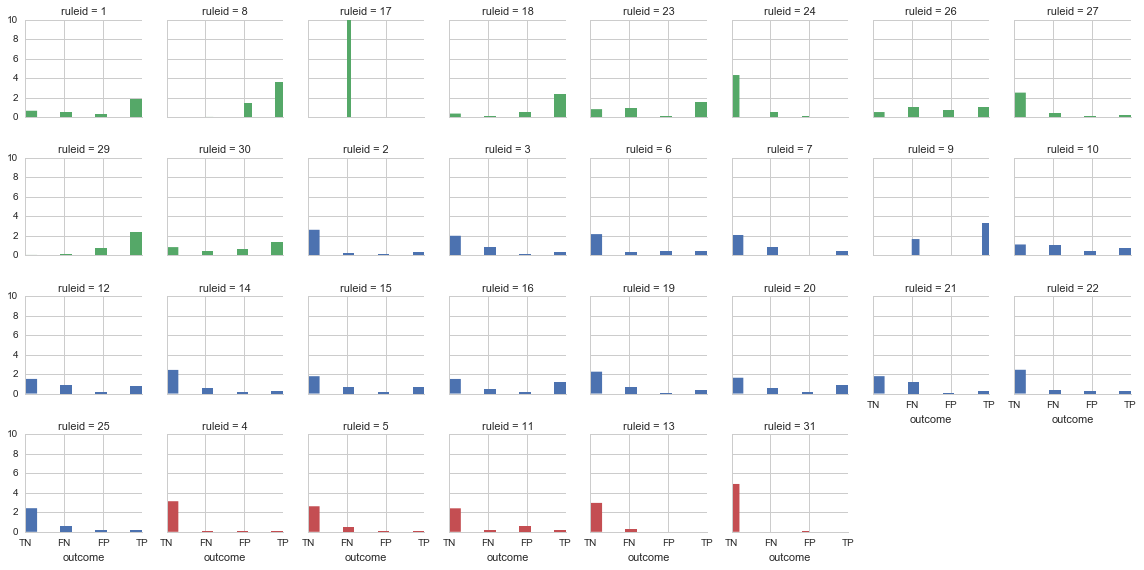

In [28]:
# Plot results as a grid of bar charts, separated by rule. 
# Color indicates the overall rule type

ruleorder = list(categories[categories.ruletype=="Fraud"].ruleid.values) + \
    list(categories[categories.ruletype=="Financial Risk"].ruleid.values) + \
    list(categories[categories.ruletype=="Compliance"].ruleid.values)

grid = sns.FacetGrid(all_numeric, 
                     col="ruleid", 
                     hue="ruletype", 
                     col_order = ruleorder,
                     col_wrap=8, size=2, aspect=1,
                     xlim=(0,3))
grid.map(plt.hist, "outcome", normed=True)
grid.set(xticks=[0,1,2,3])
grid.set_xticklabels(['TN','FN','FP','TP']);

This is one of the initial plots in the mock dashboard. It shows the overall performance of each rule sorted by outcome. **Rule 17** stands out because it has only a single triggered alert in the dataset (agent placed funds on hold, but there was no fraud involved - false negative). 

Good rules are ones dominated by true positives and where *every other category is low*; a high true negative rate would indicate that the agents are being accurate, but that the rule is overly sensitive (eg, **Rule 31**). The best at this by eye is **Rule 18**. 

Next, we'll calculate our metrics of choice (precision, recall, F1) for the dataset when split by rule. 

In [29]:
metric,value,ruleid = [],[],[]
for g in all_numeric.groupby('ruleid'):
    outcomes = {}
    for gg in g[1].groupby('outcome'):
        outcomes[gg[0]] = len(gg[1])
    TN,FN,FP,TP = [outcomes.setdefault(i, 0) for i in range(4)]
    
    p_ = get_precision(TP,FP) if (TP + FP) > 0 and TP > 0 else 0.
    r_ = get_recall(TP,FN) if (TP + FN) > 0 and TP > 0 else 0.
    if p_ > 0. and r_ > 0.:
        f_ = get_f1(TP,FP,TN,FN)
    else:
        f_ = 0.
        
    value.append(p_)
    value.append(r_)
    value.append(f_)
    
    metric.append('precision')
    metric.append('recall')
    metric.append('f1')
    ruleid.extend([g[0],]*3)

        
m = pd.DataFrame(index = range(len(metric)))
m['metric'] = pd.Series(metric)
m['value'] = pd.Series(value)
m['ruleid'] = pd.Series(ruleid)

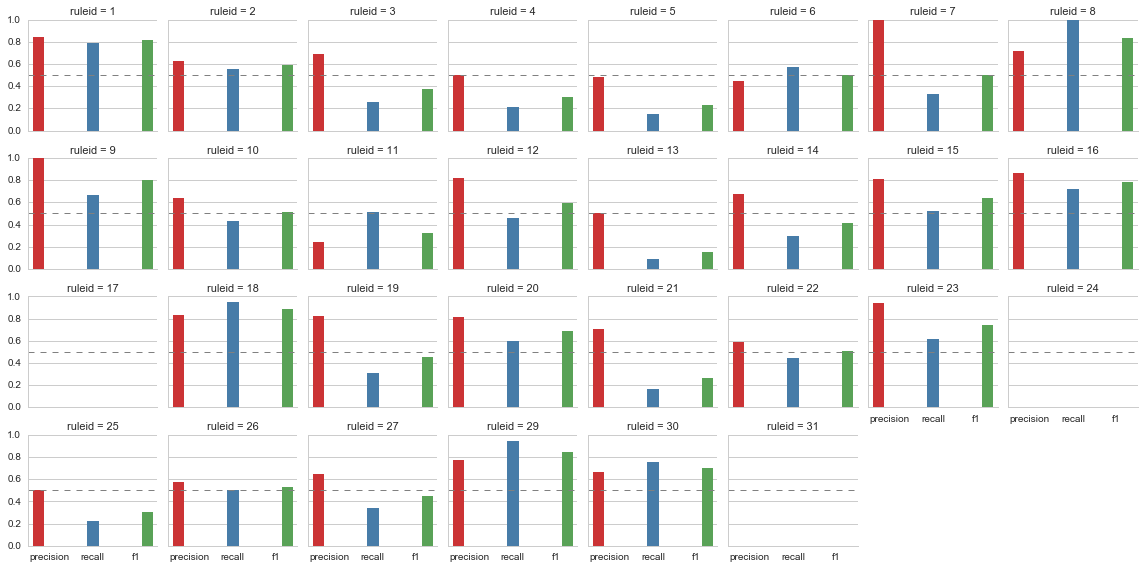

In [30]:
# Plot the metrics for the overall data split by rule

grid = sns.FacetGrid(m, 
                     col="ruleid",
                     col_wrap=8, size=2, aspect=1)
grid.map(sns.barplot, "metric","value","metric",palette=sns.color_palette("Set1"))
grid.map(plt.axhline, y=0.5, ls="--", c="0.5",lw=1);

This is a good overall summary; we have three metrics for each rule, of which the combined F1 is considered to be the most important. For any rule, we can look at the corresponding plot in the dashboard and examine whether F1 is above a chosen threshold value (labeled here as 0.5). Reading from left to right in the top row, for example, **Rule 1** is performing well, **Rule 2** is acceptable, **Rules 3-5** are performing below the desired accuracy, etc. 

### Splitting by rule type: performance metrics

Repeat the same analysis as above, but split by rule type (Fraud, Financial Risk, Compliance) instead of the rules themselves.

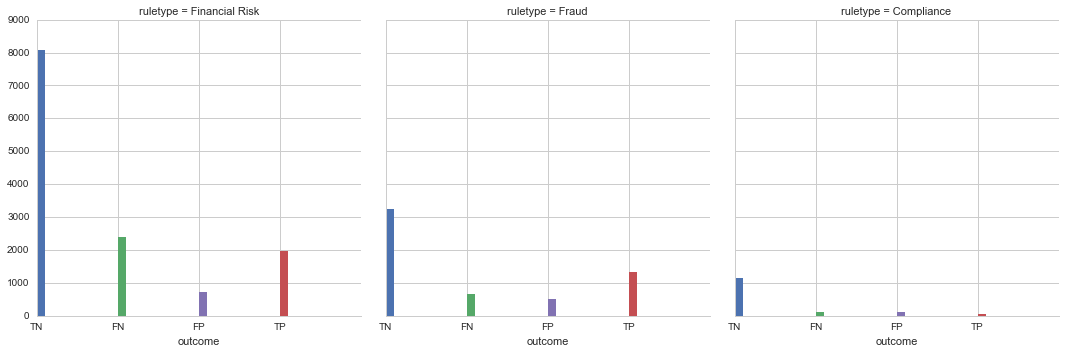

In [37]:
# Plot the counts of each outcome split by rule type.

grid = sns.FacetGrid(all_numeric, 
                     col="ruletype", hue="outcome", 
                     col_wrap=3, size=5, aspect=1,
                     xlim=(0,3))
grid.map(plt.hist, "outcome")
grid.set(xticks=[0,1,2,3,4])
grid.set_xticklabels(['TN','FN','FP','TP']);

**Financial risk** rules are the largest category, and are mostly cases that were true negatives (money not held and it wasn't a bad transaction). The false negative rate is slightly larger than the true positive, though, indicating that financial risks are missing more than half of the genuinely bad transactions. **Fraud** rules also have true negatives as the most common category, but a significantly lower false negative rate compard to true positives. So these types are less likely to be missed by the agents. **Compliance** rules trigger the fewest total number of alerts; the rates of anything except a false negative are all low (81% of these alerts are benign). 

In [38]:
# Calculate precision, recall, F1 for data by rule type

rt_metric,rt_value,rt_ruletype = [],[],[]
for g in all_numeric.groupby('ruletype'):
    outcomes = {}
    for gg in g[1].groupby('outcome'):
        outcomes[gg[0]] = len(gg[1])
    TN,FN,FP,TP = [outcomes.setdefault(i, 0) for i in range(4)]
    
    p_ = get_precision(TP,FP) if (TP + FP) > 0 and TP > 0 else 0.
    r_ = get_recall(TP,FN) if (TP + FN) > 0 and TP > 0 else 0.
    if p_ > 0. and r_ > 0.:
        f_ = get_f1(TP,FP,TN,FN)
    else:
        f_ = 0.
    
    rt_value.append(p_)
    rt_value.append(r_)
    rt_value.append(f_)
    
    rt_metric.append('precision')
    rt_metric.append('recall')
    rt_metric.append('f1')
    rt_ruletype.extend([g[0],]*3)

rtm = pd.DataFrame(index = range(len(rt_metric)))
rtm['metric'] = pd.Series(rt_metric)
rtm['value'] = pd.Series(rt_value)
rtm['ruletype'] = pd.Series(rt_ruletype)

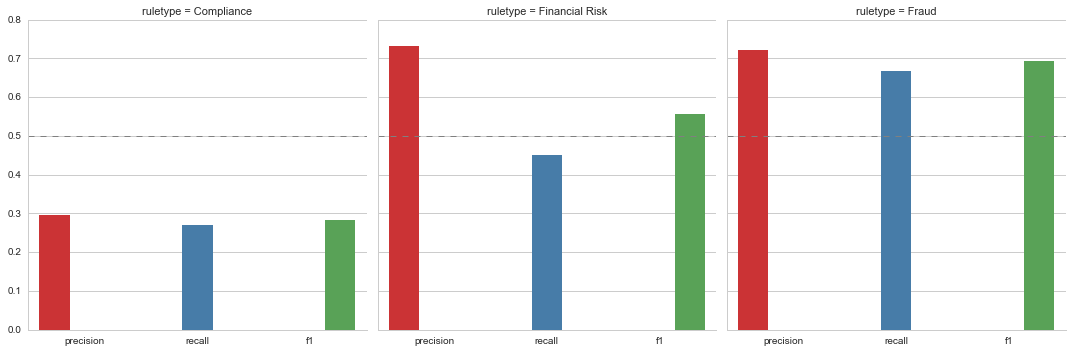

In [39]:
# Plot the overall precision, recall, F1 for the dataset split by rule type

grid = sns.FacetGrid(rtm, 
                     col="ruletype",
                     col_wrap=3, size=5, aspect=1)
grid.map(sns.barplot, "metric","value","metric",palette=sns.color_palette("Set1"))
grid.map(plt.axhline, y=0.5, ls="--", c="0.5",lw=1);

Grouping by type; **fraud** rules have by a significant amount the best performance across all three metrics. **Financial risk** has comparable precision, but much worse recall. **Compliance** is poor across the board. 

### Cumulative performance of metrics split by rule

The above dashboard is a useful start, since we've defined a metric and looked at how it differs for each rule. However, the data being used was collected over a period of several months, and the data should be examined for variations in the metrics as a function of time. This would examine whether a rule is performing well (and if it improves or degrades with more data), the response of the risk agents to different triggers, and possibly variations in the population of merchants submitting cases. 

We'll look at this analysis in the context of an *expanding window* - for every point in a time series of data, we use data up to and including that point. This gives the cumulative performance as a function of time, which is useful for looking at how the performance of a given rule stabilizes. 

In [31]:
# Compute precision, recall, and F1 over an expanding time window

def ex_precision(ts):
    TP = (ts.badmerch & ts.held).sum()
    FP = (ts.held & np.logical_not(ts.badmerch)).sum()
    if (TP + FP) > 0.:
        return TP * 1./ (TP + FP)
    else:
        return 0.

def ex_recall(ts):
    TP = (ts.badmerch & ts.held).sum()
    FN = (ts.badmerch & np.logical_not(ts.held)).sum()
    if (TP + FN) > 0.:
        return TP * 1./(TP + FN)
    else:
        return 0.

def ex_f1(ts):
    TP = (ts.badmerch & ts.held).sum()
    FP = (ts.held & np.logical_not(ts.badmerch)).sum()
    FN = (ts.badmerch & np.logical_not(ts.held)).sum()
    num = 2*TP
    den = 2*TP + FP + FN
    if den > 0.:
        return num * 1./den
    else:
        return 0.

# Make the expanded window with associated metrics by looping over every row in the dataframe

def make_expanded(ts,window=1):
    expanding_precision = pd.concat([(pd.Series(ex_precision(ts.iloc[:i+window]), 
                                                index=[ts.index[i+window]])) for i in range(len(ts)-window) ])
    expanding_recall = pd.concat([(pd.Series(ex_recall(ts.iloc[:i+window]), 
                                                index=[ts.index[i+window]])) for i in range(len(ts)-window) ])
    expanding_f1 = pd.concat([(pd.Series(ex_f1(ts.iloc[:i+window]), 
                                                index=[ts.index[i+window]])) for i in range(len(ts)-window) ])

    ex = pd.DataFrame(data={"precision":expanding_precision.values,
                            "recall":expanding_recall.values,
                            "f1":expanding_f1.values,
                           },
                            index=ts.index[1:])
    return ex

In [32]:
# Run the expanded window for all cases, sorted by ruleid

sql_query = """
SELECT cases.*,rules.ruleid
    FROM cases
    JOIN rules ON rules.caseid = cases.caseid
    ORDER BY ruleid,alertdate
    ;
"""
casejoined = pd.read_sql_query(sql_query,con)

exdict = {}
for g in casejoined.groupby("ruleid"):
    ruleid = g[0]
    df = g[1]
    ts = pd.DataFrame(data={"amount":df.amount.values,
                            "held":df.held.values,
                            "badmerch":df.badmerch.values},
                            index=df.alertdate.values)
    try:
        exdict[ruleid] = make_expanded(ts)
    except ValueError:
        print "No true positives in Rule {} ({} trigger); cannot compute expanded window.".format(ruleid,len(df))

No true positives in Rule 17 (1 trigger); cannot compute expanded window.


In [33]:
ruleid = 4

# Quick code to make single plots for presentation

"""
pl = sns.barplot(x="metric",y="value",data=m[m.ruleid==ruleid])
pl.axhline(y=0.5, ls="--", c="0.5",lw=1)
pl.set_title("RuleID = {}".format(ruleid),fontsize=20);

pl = exdict[ruleid].plot(legend=True)
pl.set_title("RuleID = {}".format(ruleid),fontsize=20)
pl.set_ylim(0,1.05)
pl.set_ylabel("metrics",fontsize=12);
"""

'\npl = sns.barplot(x="metric",y="value",data=m[m.ruleid==ruleid])\npl.axhline(y=0.5, ls="--", c="0.5",lw=1)\npl.set_title("RuleID = {}".format(ruleid),fontsize=20);\n\npl = exdict[ruleid].plot(legend=True)\npl.set_title("RuleID = {}".format(ruleid),fontsize=20)\npl.set_ylim(0,1.05)\npl.set_ylabel("metrics",fontsize=12);\n'

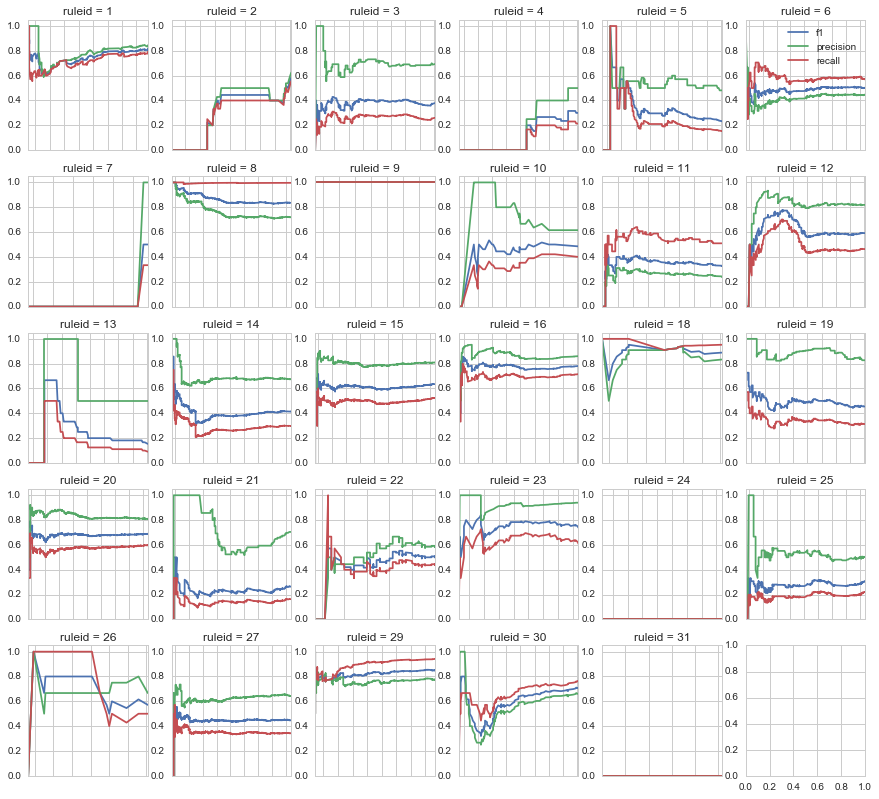

In [34]:
# Plot results in a grid

fig,axarr = plt.subplots(5,6,figsize=(15,15))
rules_sorted = sorted(exdict.keys())

for ruleid,ax in zip(rules_sorted,axarr.ravel()):
    ex = exdict[ruleid]
    pl = ex.plot(ax=ax,legend=(False | ruleid==6))
    pl.set_title("ruleid = {}".format(ruleid))
    pl.set_ylim(0,1.05)
    pl.set_xticklabels([""])

This will be the second set of plots in our dashboard. This shows the results over an expanding window covering the full length of time in the dataset, where the value of the three metrics (precision, recall, F1) track how the rules are performing with respect to the analysts and true outcomes over time. 

By definition, data over an expanding window should stabilize as more data comes in and the variance decreases (assuming that the rule definitions, performance of risk agents, and underlying merchant behavior is all the same). Large amounts of recent variation would indicate that we don't know whether the rule is performing well yet. 

To assess how much the rules are varying in performance, we'll measure the stability of each metric weighted more heavily toward the most recent results. A simple measure which will use is the largest absolute deviation over the second half of the data. 

In [35]:
# Rank rule performance by deltamax: the largest absolute deviation in the second half of the dataset.

l = []
for ruleid in exdict:
    ex = exdict[ruleid]
    ex_2ndhalf = ex.iloc[len(ex)//2:]
    f1diff = (ex_2ndhalf.f1.max() - ex_2ndhalf.f1.min())
    if np.isfinite(f1diff):
        l.append((ruleid,f1diff,len(ex_2ndhalf)))
    else:
        print "No variation for Rule {:2} in the second half (median is zero).".format(ruleid)

lsorted = sorted(l, key=lambda x: x[1],reverse=True)
for ll in lsorted:
    print "Rule {:2} varies by {:.2f} in the second half ({:4} data points)".format(*ll)

Rule  7 varies by 0.50 in the second half (   4 data points)
Rule  4 varies by 0.32 in the second half ( 144 data points)
Rule  2 varies by 0.21 in the second half (  56 data points)
Rule 30 varies by 0.15 in the second half (  67 data points)
Rule 26 varies by 0.12 in the second half (   6 data points)
Rule  5 varies by 0.11 in the second half ( 231 data points)
Rule 14 varies by 0.10 in the second half (1672 data points)
Rule 13 varies by 0.10 in the second half (  54 data points)
Rule 10 varies by 0.10 in the second half (  19 data points)
Rule  1 varies by 0.08 in the second half ( 103 data points)
Rule 19 varies by 0.07 in the second half ( 249 data points)
Rule 18 varies by 0.06 in the second half (  14 data points)
Rule 22 varies by 0.06 in the second half ( 181 data points)
Rule 21 varies by 0.06 in the second half ( 220 data points)
Rule  3 varies by 0.05 in the second half ( 232 data points)
Rule 11 varies by 0.05 in the second half ( 251 data points)
Rule 23 varies by 0.05 i

Six out of the thirty rules have a variation $\Delta_\mathrm{max,abs} < 0.1$ in the second half of the current data. Of those, two (**Rules 7 and 26**) have only a handful of datapoints and estimates of the true accuracy are very uncertain. Two others (**Rules 2 and 30**) more data, although less than 100 points each. Rule 2 has very different behavior starting a few weeks toward the end, sharply increasing both its precision and recall. This could indicate either a difference in merchant tendencies or a re-definition of the existing rule. Rule 30 has shown a gradual improvement from an early nadir, which might be a sign of a set of bad/unlikely transactions earlier and now regressing to the mean. **Rule 4** basically only has data in the second half of the set (not stabilized yet) and **Rule 5** has a gradually decreasing recall, which may be a counterexample to the trend in Rule 30. 

The remainder of the rules (especially for those with a few hundred data points) are relatively stable over the expanding window. So we can broadly categorize rule performance in three categories:

* rules that are performing well
* rules that are not performing well
* rules for which behavior is not stable/well-determined

We'll define a well-performing rule as one whose cumulative score is $F1 \ge 0.5$, and a stable rule as one with $N_\mathrm{cases}>10$ and $\Delta_\mathrm{max,abs} < 0.1$. 

In [36]:
# Sort and print the rules matching the criteria for stability and high performance.

stable_good = []
stable_bad = []
unstable = []
for ruleid in exdict:
    ex = exdict[ruleid]
    ex_2ndhalf = ex.iloc[len(ex)//2:]
    deltamax = (ex_2ndhalf.f1.max() - ex_2ndhalf.f1.min())
    f1 = ex.iloc[len(ex)-1].f1
    stable = True if deltamax < 0.1 and len(ex)//2 > 10 else False
    good = True if f1 >= 0.5 else False
    
    if stable and good:
        stable_good.append(ruleid)
    elif stable:
        stable_bad.append(ruleid)
    else:
        unstable.append(ruleid)
        
print "{:2} rules {} are performing well.".format(len(stable_good),stable_good)
print "{:2} rules {} are not performing well.".format(len(stable_bad),stable_bad)
print "{:2} rules {} are unstable and cannot be evaluated yet.".format(len(unstable),unstable)

11 rules [1, 6, 8, 12, 15, 16, 18, 20, 22, 23, 29] are performing well.
10 rules [3, 10, 11, 13, 19, 21, 24, 25, 27, 31] are not performing well.
 8 rules [2, 4, 5, 7, 9, 14, 26, 30] are unstable and cannot be evaluated yet.


### Cumulative performance of metrics split by rule type

In [40]:
# Compute the change in performance by rule type over an expanding time window

sql_query = """
SELECT cases.*,categories.ruletype
    FROM cases
    JOIN rules ON rules.caseid = cases.caseid
    JOIN categories on categories.ruleid = rules.ruleid
    ORDER BY categories.ruletype,alertdate
    ;
"""
rtjoined = pd.read_sql_query(sql_query,con)

# Get the dataframes
rtd = {}
for g in rtjoined.groupby("ruletype"):
    ruletype = g[0]
    df = g[1]
    ts = pd.DataFrame(data={"amount":df.amount.values,
                            "held":df.held.values,
                            "badmerch":df.badmerch.values},
                            index=df.alertdate.values)
    try:
        rtd[ruletype] = make_expanded(ts)
    except ValueError:
        print "Problems with {}".format(ruletype)

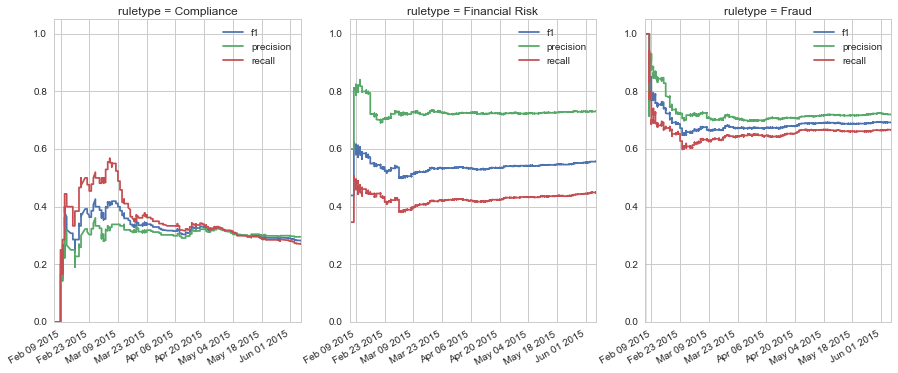

In [41]:
# Plot results in a grid

fig,axarr = plt.subplots(1,3,figsize=(15,6))
rules_sorted = sorted(rtd.keys())

for ruletype,ax in zip(rules_sorted,axarr.ravel()):
    ex = rtd[ruletype]
    pl = ex.plot(ax=ax)
    pl.set_title("ruletype = {}".format(ruletype))
    pl.set_ylim(0,1.05)

In [42]:
# Rank rules by the largest absolute deviation in the second half of the dataset.

l = []
for ruletype in rtd:
    ex = rtd[ruletype]
    ex_2ndhalf = ex.iloc[len(ex)//2:]
    f1diff = (ex_2ndhalf.f1.max() - ex_2ndhalf.f1.min())
    l.append((ruletype,f1diff,len(ex_2ndhalf)))

print ''
lsorted = sorted(l, key=lambda x: x[1],reverse=True)
for ll in lsorted:
    print "{:15} rules vary by {:.2f} in the second half ({:4} data points)".format(*ll)


Compliance      rules vary by 0.05 in the second half ( 709 data points)
Financial Risk  rules vary by 0.03 in the second half (6577 data points)
Fraud           rules vary by 0.03 in the second half (2876 data points)


Analysis: all three of the rule type have a variation $\Delta_\mathrm{max,abs} \le 0.05$ in the second half of the current data. Since all three rule types have at least hundreds of data points distributed over time, stability is mostly expected. **Compliance** rules still show the largest deviations; there was a large amount of early variance, which is more stable but still mildly decreasing. Both **fraud** and **financial risk** have been quite stable following about the first month of data. 

### Rolling performance of metrics split by rule

The analysis above is useful from an overall perspective about whether a rule has been historically justified. For data scientists and risk analysts, however, it is also critical to look only at **recent** data so that action can be taken if performance starts to drastically change. Expanding windows do not work well for this since the data are weighted over all input and it will take time for variations to affect the integrated totals. Instead, we will run a similar analysis on a *rolling window* to look for changes on a weekly timescale. 

In [43]:
ts = pd.DataFrame(data={"amount":cases.amount.values,
                            "held":cases.held.values,
                            "badmerch":cases.badmerch.values},
                            index=cases.alertdate.values)
r = ts.rolling(window=7,min_periods=1)

In [44]:
# Make a rolling window with associated metrics by looping over every row in the dataframe

def r_precision(ts):
    TP = (ts.badmerch & ts.held).sum()
    FP = (ts.held & np.logical_not(ts.badmerch)).sum()
    if (TP + FP) > 0.:
        return TP * 1./ (TP + FP)
    else:
        return np.nan

def r_recall(ts):
    TP = (ts.badmerch & ts.held).sum()
    FN = (ts.badmerch & np.logical_not(ts.held)).sum()
    if (TP + FN) > 0.:
        return TP * 1./(TP + FN)
    else:
        return np.nan

def r_f1(ts):
    TP = (ts.badmerch & ts.held).sum()
    FP = (ts.held & np.logical_not(ts.badmerch)).sum()
    FN = (ts.badmerch & np.logical_not(ts.held)).sum()
    num = 2*TP
    den = 2*TP + FP + FN
    if den > 0.:
        return num * 1./den
    else:
        return np.nan

def make_rolling(ts,window):
    
    rolling_precision = pd.concat([(pd.Series(r_precision(ts.iloc[i:i+window]), 
                                                index=[ts.index[i+window]])) for i in range(len(ts)-window) ])
    rolling_recall = pd.concat([(pd.Series(r_recall(ts_sorted.iloc[i:i+window]), 
                                                index=[ts.index[i+window]])) for i in range(len(ts)-window) ])
    rolling_f1 = pd.concat([(pd.Series(r_f1(ts.iloc[i:i+window]), 
                                                index=[ts.index[i+window]])) for i in range(len(ts)-window) ])

    r = pd.DataFrame(data={"precision":rolling_precision.values,
                            "recall":rolling_recall.values,
                            "f1":rolling_f1.values,
                           },
                            index=rolling_f1.index)
    return r

In [45]:
# Run the rolling window for all cases, sorted by rule

rdict = {}
for g in casejoined.groupby("ruleid"):
    ruleid = g[0]
    df = g[1]
    ts = pd.DataFrame(data={"amount":df.amount.values,
                            "held":df.held.values,
                            "badmerch":df.badmerch.values},
                            index=df.alertdate.values)
    ts_sorted = ts.sort_index()
    try:
        rdict[ruleid] = make_rolling(ts_sorted,window=50)
    except ValueError:        
        print "No true positives in Rule {} over interval ({} triggers); cannot compute rolling window.".format(ruleid,len(df))
        # Empty dataframe
        rdict[ruleid] = pd.DataFrame([0,]*len(df),index=[[casejoined.alertdate.min(),]*(len(df)-1) + [casejoined.alertdate.max()]])

No true positives in Rule 7 over interval (8 triggers); cannot compute rolling window.
No true positives in Rule 9 over interval (3 triggers); cannot compute rolling window.
No true positives in Rule 10 over interval (39 triggers); cannot compute rolling window.
No true positives in Rule 17 over interval (1 triggers); cannot compute rolling window.
No true positives in Rule 18 over interval (28 triggers); cannot compute rolling window.
No true positives in Rule 26 over interval (13 triggers); cannot compute rolling window.


//anaconda/lib/python2.7/site-packages/matplotlib/axes/_base.py:2767: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=735755.0, right=735755.0
  'left=%s, right=%s') % (left, right))


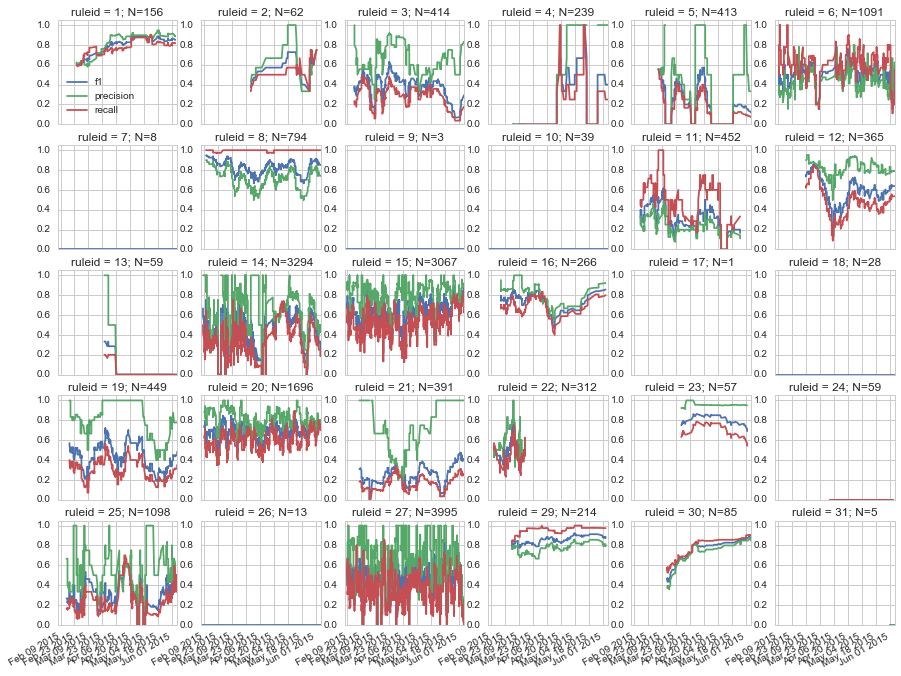

In [46]:
# Plot the dashboard with rolling windows

fig,axarr = plt.subplots(5,6,figsize=(15,12))
for ax,r in zip(axarr.ravel(),rdict):
    rp = rdict[r].plot(xlim=(casejoined.alertdate.min(),casejoined.alertdate.max()),
                       ylim=(0,1.05),
                       ax=ax,
                       legend=(False | r == 1))
    if r < 25:
        rp.set_xticklabels([""])
    rp.set_title("ruleid = {}; N={}".format(r,len(rdict[r])));

### Rolling performance of metrics split by rule type

In [47]:
# Same rolling analysis, but by rule type

rtrdict = {}
for g in rtjoined.groupby("ruletype"):
    ruleid = g[0]
    df = g[1]
    ts = pd.DataFrame(data={"amount":df.amount.values,
                            "held":df.held.values,
                            "badmerch":df.badmerch.values},
                            index=df.alertdate.values)
    ts_sorted = ts.sort_index()
    try:
        rtrdict[ruleid] = make_rolling(ts_sorted,window=200)
    except ValueError:        
        print "No true positives in Rule {} over interval ({} triggers); cannot compute rolling window.".format(ruleid,len(df))
        # Empty dataframe
        rtrdict[ruleid] = pd.DataFrame([0,]*len(df),index=[[casejoined.alertdate.min(),]*(len(df)-1) + [casejoined.alertdate.max()]])

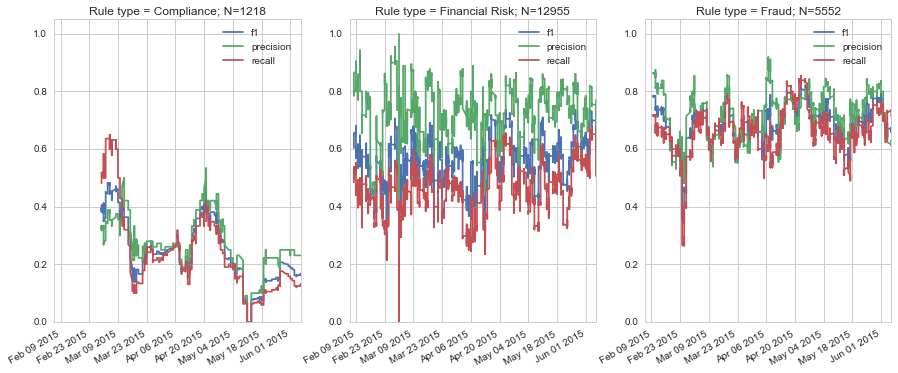

In [48]:
# Plot the dashboard with rolling windows by rule type

fig,axarr = plt.subplots(1,3,figsize=(15,6))
for ax,r in zip(axarr.ravel(),["Compliance","Financial Risk","Fraud"]):
    rp = rtrdict[r].plot(xlim=(rtjoined.alertdate.min(),rtjoined.alertdate.max()),
                       ylim=(0,1.05),
                       ax=ax)
    rp.set_title("Rule type = {}; N={}".format(r,len(rtrdict[r])));

## Co-occurence and effectiveness of rules

Are there any rules that occur together at very high rates (indicating that the model is too complicated)?

In [49]:
# Compute the co-occurrence matrix for triggering rules

df = pd.DataFrame(index=rules.caseid.unique())

rule_count_arr = np.zeros((len(rules.caseid.unique()),30),dtype=int)
for idx,g in enumerate(rules.groupby('caseid')):
    g1 = g[1]
    for r in g1.ruleid.values:
        # Numbering is a little off because there's no Rule 28 in the dataset.
        if r < 28:
            rule_count_arr[idx,r-1] = 1
        else:
            rule_count_arr[idx,r-2] = 1

In [50]:
# Create pandas DataFrame and rename the columns to the actual rule IDs

df = pd.DataFrame(data=rule_count_arr,
                  index=rules.caseid.unique(),
                  columns=[sorted(rules.ruleid.unique())])

# Co-occurrence matrix is the product of the matrix and its transpose

coocc = df.T.dot(df)
coocc.head()

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,29,30,31
1,206,0,1,0,0,3,0,13,1,1,...,0,1,1,1,1,0,22,3,3,0
2,0,112,2,0,0,0,0,11,0,0,...,0,0,0,5,37,0,50,0,3,0
3,1,2,464,0,0,0,0,12,0,0,...,10,1,0,0,47,0,69,2,9,0
4,0,0,0,289,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,0,0,0,0,463,0,0,2,0,0,...,0,0,0,13,9,0,0,1,0,0


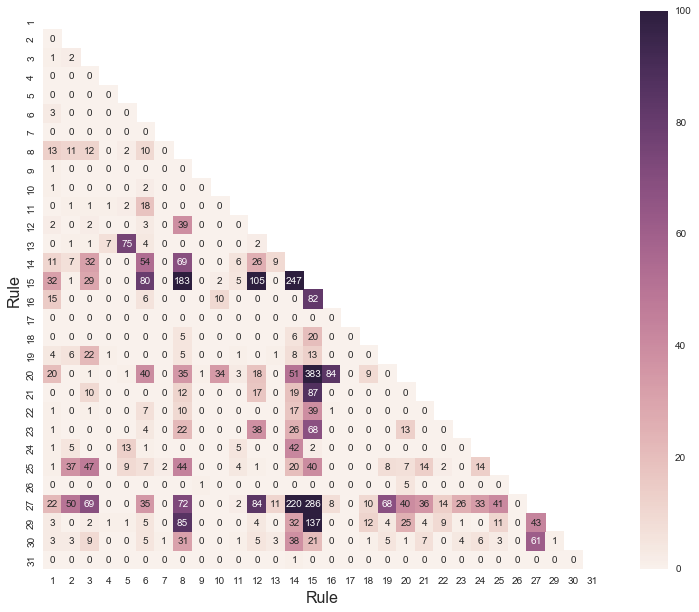

In [51]:
# Plot the co-occurrence matrix and mask the diagonal and upper triangle values
# (mirrored on the bottom half of the matrix)

fig,ax = plt.subplots(1,1,figsize=(14,10))
mask = np.zeros_like(coocc)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    sns.heatmap(coocc,
                mask = mask,
                annot=True, fmt="d",
                vmax = 100,
                square=True,
                ax=ax)
    ax.set_xlabel('Rule',fontsize=16)
    ax.set_ylabel('Rule',fontsize=16);

**Rules 8, 14, 15, and 27** all have fairly strong co-occurrences with other rules in the set. These would be good candidates to check for the overall F1 scores and evaluate whether they're a necessary trigger for the system. 

Other questions that I'd explore in the data given more time:

* What fraction of the triggers for each rule are co-occurrences?
* What are the F1 scores produced by combinations of rules?
* How do the combined F1 scores compare to the scores when triggered individually?

## Predicting whether a transaction is fraudulent

None of this analysis has actually attempted to predict the effectiveness of the rule system in place; right now, it only evaluates it with respect to the hold decisions and the ultimate labels. Given more time, it should be very tractable to build a machine learning classifier that:

* predicts the likelihood of being a bad transaction (based on merchant, past history, timestamp, and amount)
* predicts the likelihood of funds being withheld given that it is a bad transaction
* recommends triggering the rule by minimizing the false negative rate while maintaining specificity

I'd start with a simple logistic regression model and assess performance with cross-validation on later times in the dataset; depending on the accuracy, ensemble models such as random forests or support vector machines would also be good candidates for increased accuracy. If none of those achieve the desired accuracy, the next step would be trying the performance of a neural net. 

In [52]:
# How much money did bad transactions cost Insight in this dataset?

print "Bad money in transactions totals ${:.2f}.".format(cases[(cases.held == 0) & (cases.badmerch == 1)].amount.sum())

Bad money in transactions totals $8323260.20.
